In [1]:
# packages
import sys
import os
import numpy as np

sys.path.insert(0, os.path.abspath("../ssh-kd"))
from plugin.seg import remove_outliers, helper_object_points
from utils.data_prep import read_file, get_outliers


# hidding the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Clustering
from sklearn.cluster import DBSCAN
def _cluster(X_):
    """ cluster using dbscan.
        params: X_ = list of x,y point
        return: lables
    """
    clustering = DBSCAN(eps=1, min_samples=8).fit(X_)
    labels = clustering.labels_
    return labels

In [3]:
def format_data(df):
    """ format data for cluster input.
        params: df = dataframe with transform _x,_y
        return: numpy array of x,y point
    """
    return np.array(list(zip(np.array(df["_x"]),np.array(df["_y"]))))

In [4]:
def normalize(df):
    """ Normalize the point using min_max normalizer.
        params: df = dataframe with transform _x,_y
        return: df with normalized _x,_y points
    """
    df['_x'] = (df['_x']-df['_x'].min())/(df['_x'].max()-df['_x'].min())
    df['_y'] = (df['_y']-df['_y'].min())/(df['_y'].max()-df['_y'].min())
    return df

In [5]:
def project(df, d, view):
    """ Project with prespective projections.
        formula: x' = x*d/z
                 y' = y*d/z
        params: df = dataframe with with x,y,z points
                d =  distance of prespective projection
                view = w.r.t X , w.r.t Z
        return: df with transformed _x,_y points in df
    """
    v= "X" if view == "X" else "Z"
    z= "X" if view == "Z" else "Z"
    df['_x'] = ((df[z]/df[v])*d)
    df['_y'] = ((df['Y']/df[v])*d)
    return df

In [6]:
def cabin_projection(df,alpha):
    """ Project with cabin projections.
        formula: x' = x + 0.5*cos(alpha)*z
                 y' = y + 0.5*cos(alpha)*z
        params: df = dataframe with with x,y,z points
                alpha =  angle of projection
        return: df with transformed _x,_y points in df
    """
    df['_x'] = (df['X']+(0.5*df['Z'])*np.cos(np.deg2rad(alpha)))
    df['_y'] = (df['Y']+(0.5*df['Z'])*np.sin(np.deg2rad(alpha)))
    return df
    

In [7]:
def get_data(object_type,object,num_scenes):
    """ Load the data from dataset and apply ground removal and outlinear removal.
        params: object_type = train or test 
                object =  Name of the object
        return: dataframe of the data
    """
    dataset_dir = "../dataset/train"
    # Create the outliers
    get_outliers(dataset_dir)
    # Creating the path for the object
    object_path = "../{}/{}/in.csv".format("dataset/{}".format(object_type), object)
    # read in the object of choice
    dataframes = read_file(object_path, num_scenes)
    # remove the outliers
    no_outliers = remove_outliers(dataframes, num_scenes, '../ssh-kd/data/outliers.pkl')
    # get the object points
    return no_outliers

In [8]:
import matplotlib.pyplot as plt
def plot_g(x,y,xlim,ylim,c=False,centroid=False):
    """ Plot the points using matplotlib.
        params: x = x points
                y = y points
                xlim = (x_max,x_min) xrange limits for plots
                ylim = (y_max,y_min) yrange limits for plots
                c = colors if avaliable else False
                centroid = centre point (lidar position)
        return: plot is plotted
    """
    fig = plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
    ax = fig.gca()
    if c:
        plt.scatter(x, y, s=4, c=c)
    else:
        plt.scatter(x, y, s=4)
    if centroid:
        plt.scatter(0, 0, s=400, c="red")
    plt.grid()
    
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])
    plt.show()
    

In [9]:
# Experimenting with train data
no_outliers = get_data("train","BmwX5Simple", num_scenes=50)

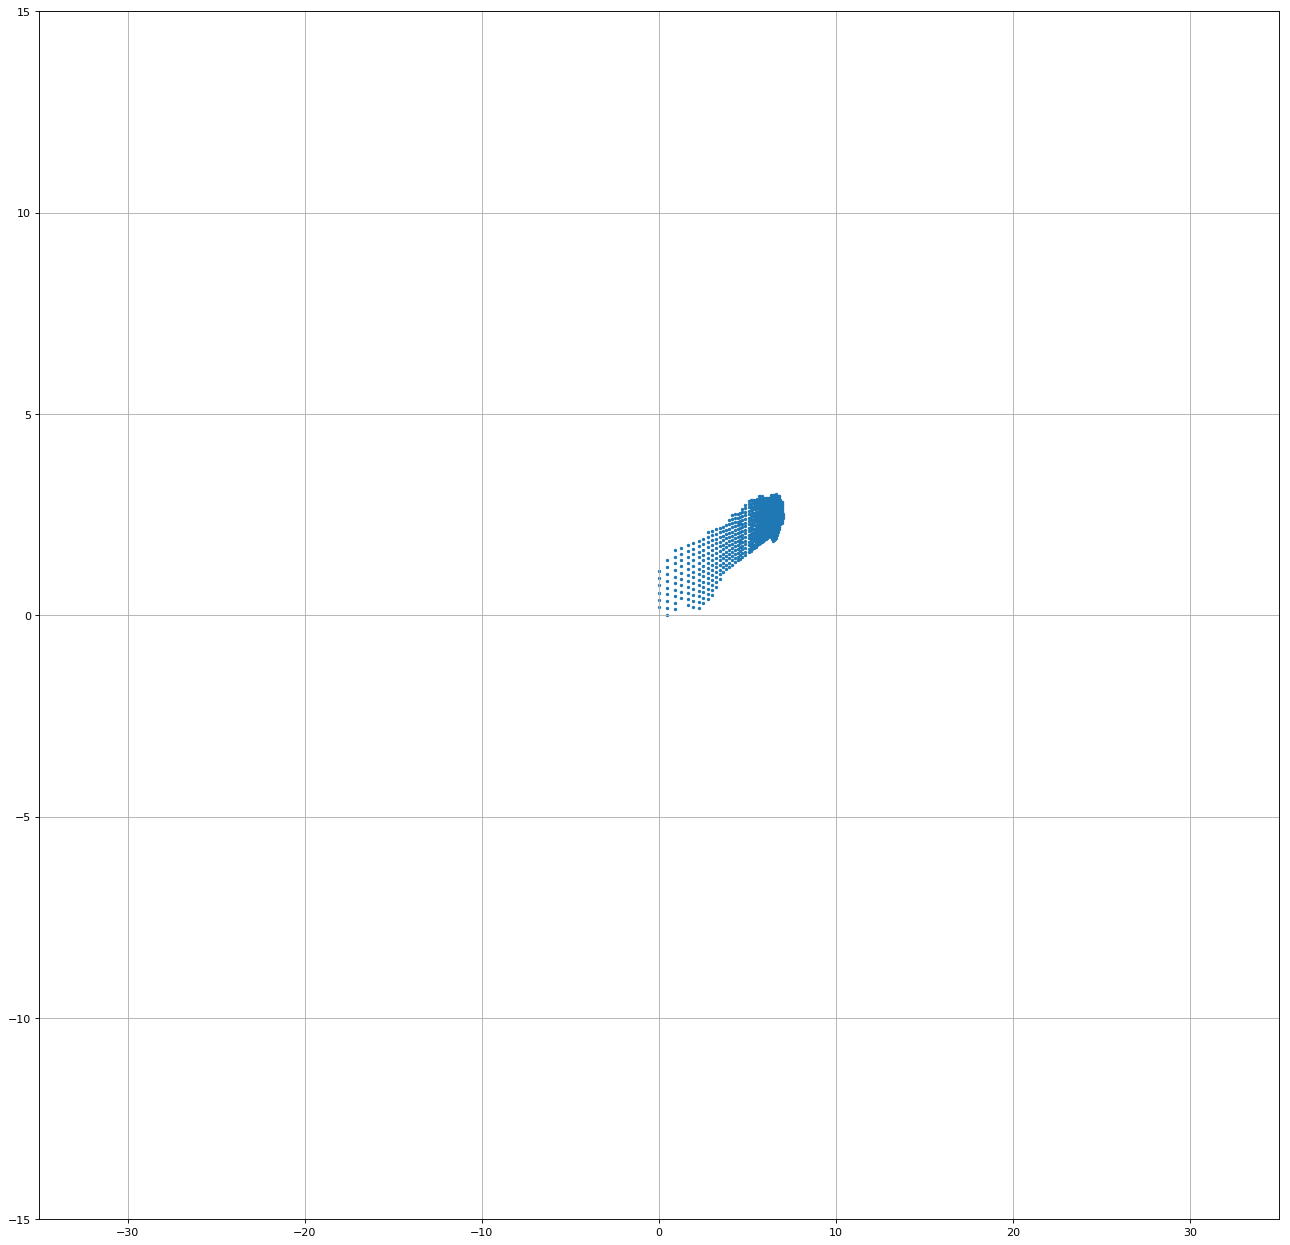

In [10]:
# Get Each scene and work on it, scene selected 6
scene_df = helper_object_points(no_outliers[6], 4)
# Apply projection
proj_df = project(scene_df, 5,view="Z")
# Apply normalization 
proj_df = normalize(proj_df)
# Plot the transformation
plot_g(7*proj_df['_x'],3*proj_df['_y'],(-35,35),(-15,15))

In [11]:
# Experiment with Test data 
no_outliers = get_data("test", "Set2", num_scenes=500)

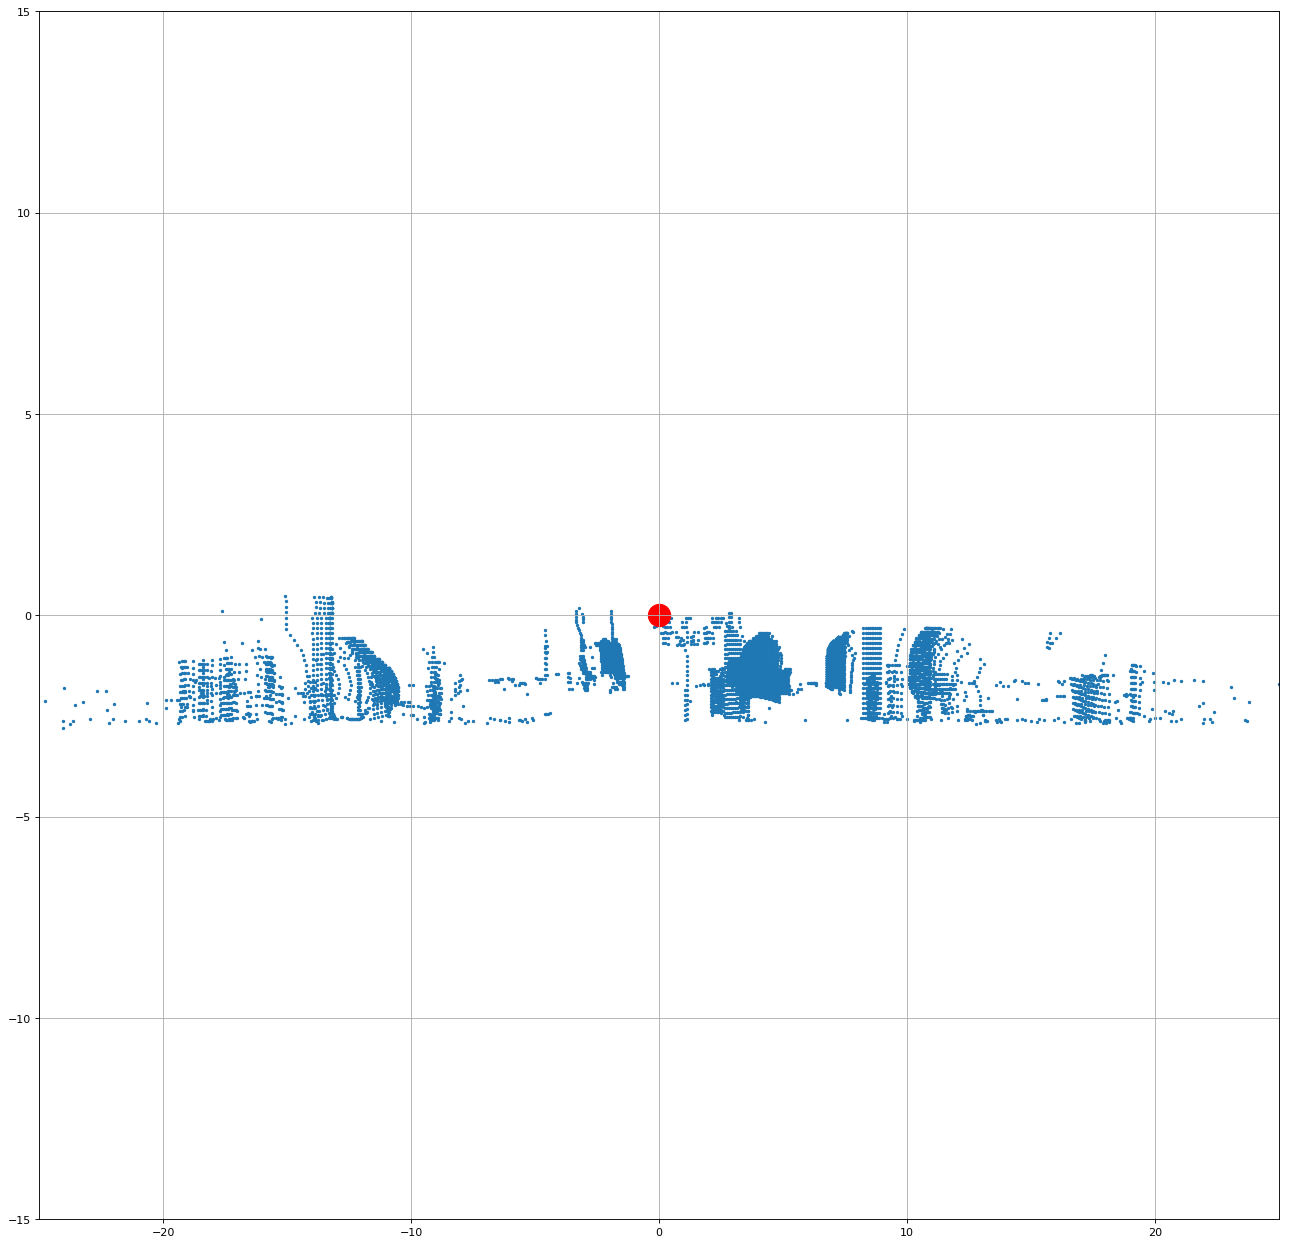

In [12]:
# Get the data for a scene - 6 
scene_df = helper_object_points(no_outliers[6], 4)

# Apply projection
# proj_df = project(scene_df, 5)

# Apply normalization
# proj_df = normalize(proj_df)

# Plot 
plot_g(scene_df['Z'],scene_df['Y'],(-25,25),(-15,15),centroid=True)

In [13]:
# Plot 3d points with plotly 
import plotly
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
plotly.offline.init_notebook_mode(connected=True)

def plot_plotly(x,y,z):
    trace = go.Scatter3d(x=x,y=y,z=z,mode='markers',marker=dict(color='rgb(0, 0, 0)',size=2,opacity=0.6))
    data = [trace]
    layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        nticks=4, range = [-100,100],),
                    yaxis = dict(
                        nticks=4, range = [-50,100],),
                    zaxis = dict(
                        nticks=4, range = [-100,100],),)
                  )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig, filename='simple-3d-scatter')

In [58]:
import math
# calculating degree
calDegrees=lambda x : round(math.degrees(math.atan(x)), 1)
vfunc = np.vectorize(calDegrees)
def tang(x,y):
    """ Get Tan inverse of y/x to get the angle."""
    tag= np.divide(y, x)
    return tag


def get_degrees(c):
    """ Get the degree for the data based upon cordinate plane.
    Tan behaviour in cordinate system.
    1st cord: theta
    2nd cord: 180+theta
    3rd cord: 180+theta
    4th cord: 360-theta
    return: degree of dataframe rows
    """
    degrees =  vfunc(tang(c['X'],c['Z']))
    if (c['X']<0 and c['Z']>0) or(c['X']<0 and c['Z']<0):
        degrees = 180+degrees
    if (c['X']>0 and c['Z']<0):
        degrees = 360-degrees
    return degrees


def angle_of_elevation(x,y,z):
    """Get Tan inverse of y/sqrt(x^2+z^2) to get the angle"""
    den = math.sqrt(x**2+z**2)
    etan= np.divide(y,den)
    return etan 


def get_phi(c):
    """ Get the degree for the data based upon cordinate plane.
    return: degree of dataframe rows
    """
    phi =  vfunc(angle_of_elevation(c['X'],c['Y'],c['Z']))
    phi =  90-phi
    return phi


def get_r(x,y,z):
    """Get density r"""
    den = x**2+z**2
    return den 

def get_den(c):
    r = get_r(c['X'],c['Y'],c['Z'])
    return r

# Using Dataframe apply, a func is run on dataframe, pass the datafram to get_degrees
scene_df['angles'] = scene_df.apply(get_degrees,axis=1)
scene_df['phi'] = scene_df.apply(get_phi,axis=1)
scene_df['r'] = scene_df.apply(get_den,axis=1)

def stock_sectors(degr, stock,interval = 0.7):
    """ Split the degree in sectors based upon on the gap.
    params: degr=sorted list of unqiue degrees
            stock=List which contains the ranges of degree of a sector
            interval=step range of degree for look up 
    return stock=list contain the ranges of degree of a sector
    """
    sector= [degr[0]]
    for i in range(1, len(degr)):
        if degr[i]-degr[i-1]>interval:
            stock.append(sector)
            sector = []
        sector.append(degr[i])
    stock.append(sector)
    return stock

# convert the numpy array in list
deg = [float(d) for d in scene_df['angles']]
s = []
# apply the sorting
sorted_degrees = sorted(list(set(deg)))
# apply the stock_sector for breaking the sectors
s = stock_sectors(sorted_degrees,s)
print("Number of sectors:",len(s))

total_ind = 0 
total_r = 0
# Experiment with a sector, sector selected=18 
for i, each_s in enumerate(s):
    after_df = scene_df[scene_df['angles'] <= max(each_s)] 
    after_df = after_df[after_df['angles'] >= min(each_s)]
    if after_df.shape[0]<10:
        continue
    # convert the numpy array in list
    phis = [float(d) for d in after_df['phi']]
    si = []
    # apply the sorting
    sorted_deg = sorted(list(set(phis)))
    # apply the stock_sector for breaking the sectors
    si = stock_sectors(sorted_deg,si)
    total_ind += len(si)
    print("sectors based on phi:",len(si))
    for each_si in si:
        r_df = after_df[after_df['phi'] <= max(each_si)] 
        r_df = r_df[r_df['phi'] >= min(each_si)]
        if r_df.shape[0]<10:
            continue
        # convert the numpy array in list
        rs = [round(float(d),1) for d in r_df['r']]
        rsi = []
        # apply the sorting
        sorted_deg = sorted(list(set(rs)))
#         print(sorted_deg)
        if sorted_deg:
            # apply the stock_sector for breaking the sectors
            rsi = stock_sectors(sorted_deg,rsi, interval=100)
        print("sectors based on r:",len(rsi))
        for each_rsi in rsi:
            if len(each_rsi) < 3:
                continue
            ri_df = r_df[r_df['r'] <= max(each_rsi)] 
            ri_df = ri_df[ri_df['r'] >= min(each_rsi)]
            if ri_df.shape[0]<10:
                continue
            else:
                total_r += 1

        
print("total_ind:",total_ind, "total_r:",total_r)
# plot_g(after_df['Z'],after_df['Y'],(-25,25),(-25,25),centroid=True)

Number of sectors: 29
sectors based on phi: 1
sectors based on r: 2
[[294.5, 295.4, 303.4, 307.6, 307.9, 311.5, 313.0, 324.7, 325.0, 327.0, 327.2, 327.9, 330.5, 332.2, 334.2, 334.8, 336.8, 337.7, 338.4, 340.3, 343.4, 345.5, 346.8, 349.9, 356.0, 358.5, 364.8, 370.9], [1168.6]] max: 370.9 min: 294.5
sectors based on phi: 1
sectors based on r: 1
[[276.9, 279.7, 280.8, 281.1, 289.9, 296.3, 311.1, 311.8, 316.6, 319.2, 328.0, 331.9, 332.1, 333.0, 333.3, 333.7, 333.8, 334.2, 334.6, 335.1, 335.6, 336.4, 337.2, 337.4, 338.2, 338.7, 340.5, 342.5, 350.1]] max: 350.1 min: 276.9
sectors based on phi: 1
sectors based on r: 2
[[285.1, 286.9, 287.2, 288.7, 288.9, 292.0, 321.1, 322.9, 326.0, 334.7, 338.2, 342.7, 343.7, 352.6, 353.7, 358.2, 359.6, 361.2, 361.5, 368.1, 369.1, 369.2, 374.3, 376.4, 377.7, 380.9, 394.7, 399.9], [1186.3, 1209.8, 1209.9, 1216.0]] max: 399.9 min: 285.1
[[285.1, 286.9, 287.2, 288.7, 288.9, 292.0, 321.1, 322.9, 326.0, 334.7, 338.2, 342.7, 343.7, 352.6, 353.7, 358.2, 359.6, 361.2

[[266.4, 266.8, 270.3, 270.8, 271.4, 271.9, 272.1, 272.3, 272.6, 272.7, 272.8, 272.9, 273.2, 273.3, 273.4, 273.5, 273.6, 273.8, 273.9, 274.1, 274.7, 274.8, 275.0, 275.1, 275.3, 275.6, 275.7, 275.9, 276.0, 276.1, 276.2, 276.6, 276.7, 276.8, 277.2, 277.8, 278.3, 278.8, 278.9, 279.0, 279.1, 279.2, 279.3, 279.4, 279.5, 280.0, 280.1, 280.3, 280.6, 280.8, 281.2, 283.1, 285.0, 287.3, 296.7, 364.9], [690.3], [980.1], [2148.8, 2163.9], [2897.0, 2921.8, 2945.8]] max: 2945.8 min: 2897.0
sectors based on phi: 1
sectors based on r: 2
[[263.8, 264.8, 265.5, 266.3, 267.1, 268.0, 273.3, 274.9, 275.8, 275.9, 277.4, 277.7, 278.1, 278.5, 278.7, 279.2, 279.7, 280.6, 281.0, 281.5, 281.6, 288.7, 289.7, 290.6, 291.8, 292.3, 292.6, 292.7, 293.2, 293.4, 293.8, 294.2, 294.5, 295.5, 295.6, 296.1, 296.9, 297.9, 298.3, 298.9, 299.3, 299.5, 299.7, 300.2, 300.9, 301.5, 302.1, 302.7, 303.4, 303.9, 304.5, 305.3, 305.8, 306.4, 307.8, 310.4, 313.3, 324.0, 358.2, 359.6, 360.4, 361.2, 362.3, 363.5, 363.9, 388.0, 388.4, 38

sectors based on phi: 2
sectors based on r: 4
[[368.5, 369.8, 370.9, 372.5, 372.7, 372.8, 373.0, 373.5, 374.5, 374.6, 375.2, 375.5, 375.7, 375.8, 375.9, 376.0, 376.1, 376.4, 378.2, 378.4, 378.9, 379.0, 379.1, 379.2, 379.3, 380.2, 380.4, 380.8, 381.0, 381.1, 381.6, 381.7, 382.2, 382.3, 382.4, 382.5, 382.6, 382.7, 383.0, 383.6, 385.6, 385.8, 385.9, 386.0, 386.1, 387.5, 387.6, 389.1, 389.3, 389.4, 389.5, 389.6, 390.5, 391.2, 392.3, 392.7, 393.4, 393.8, 393.9, 394.0, 394.1, 394.2, 396.3, 397.2, 397.5, 397.6, 397.8, 398.1, 398.2, 400.9, 401.2, 401.6, 403.4, 403.9, 407.0, 407.7, 409.4, 409.6, 409.7, 410.0, 410.3, 410.8, 411.6, 411.9, 412.2, 412.9, 413.3, 413.4, 413.6, 414.0, 414.1, 415.1, 415.3, 415.9, 416.6, 417.6, 418.0, 418.1, 418.2, 418.4, 418.6, 419.0, 419.2, 419.3, 419.4, 420.0, 420.2, 420.4, 420.6, 420.9, 421.3, 421.4, 421.5, 421.6, 421.7, 421.8, 422.1, 422.3, 422.4, 422.5, 423.4, 423.8, 424.3, 424.9, 425.7, 425.8, 425.9, 426.0, 426.1, 426.2, 426.3, 426.4, 426.7, 426.9, 427.1, 427.2, 

sectors based on phi: 1
sectors based on r: 5
[[364.3, 364.4, 368.6, 368.7, 369.8, 370.1, 370.3, 371.1, 371.2, 373.1, 373.8, 374.4, 384.8, 399.8, 411.1, 412.5, 421.6, 429.4, 429.5, 430.4, 431.2, 437.3, 437.7, 438.2, 444.4, 447.9, 453.1, 454.6, 454.7, 455.0, 455.2, 456.9, 458.5, 478.5, 480.0, 507.8, 550.3, 551.2, 553.3, 574.0, 589.0, 599.4, 633.2, 689.5, 699.9], [808.4, 820.4], [1043.3, 1056.6], [1213.2, 1248.5, 1256.4], [1527.2]] max: 699.9 min: 364.3
[[364.3, 364.4, 368.6, 368.7, 369.8, 370.1, 370.3, 371.1, 371.2, 373.1, 373.8, 374.4, 384.8, 399.8, 411.1, 412.5, 421.6, 429.4, 429.5, 430.4, 431.2, 437.3, 437.7, 438.2, 444.4, 447.9, 453.1, 454.6, 454.7, 455.0, 455.2, 456.9, 458.5, 478.5, 480.0, 507.8, 550.3, 551.2, 553.3, 574.0, 589.0, 599.4, 633.2, 689.5, 699.9], [808.4, 820.4], [1043.3, 1056.6], [1213.2, 1248.5, 1256.4], [1527.2]] max: 1256.4 min: 1213.2
sectors based on phi: 1
sectors based on r: 1
[[365.7, 366.4, 367.1, 367.5, 374.8, 374.9, 375.0, 375.1, 375.2, 375.3, 376.6, 376.7, 

In [ ]:
# Plot with plotly 
x = tuple(after_df['X'].tolist())
y = tuple(after_df['Y'].tolist())
z = tuple(after_df['Z'].tolist())

plot_plotly(x,y,z)

In [ ]:
# apply projections
proj_df = project(after_df,4,view="X")
# apply normalization
proj_df = normalize(proj_df)
# plot
plot_g(proj_df['_x'],proj_df['_y'],(-2.5,2.5),(-2.5,2.5))

In [ ]:
# format data for clustering
formatted_=format_data(proj_df)

# cluster using dbscan
labels = _cluster(formatted_)

# trick for bypassing outlier error  
labels=[i if i>0 else 999 for i in labels]

# Plot
plot_g(proj_df['_x'],proj_df['_y'],(-10,10),(-10,10),c=labels,centroid=True)

In [35]:
def get_output(object_type,object):
    """ Gather the original output from out.csv.
    params: object: object name 
            object_type: train or test
    return clus: list containing number of object per scene
    """
    output_path = "../{}/{}/out.csv".format("dataset/{}".format(object_type), object)
    out_file = open(output_path, 'r').readlines()
    outfile = [i.rstrip() for i in out_file]
    outfile = [i.split(',') for i in outfile]
    outfile = [i[1:] for i in outfile]

    outfile_list = []
    out_cluster = []
    for i in outfile:
        a  = {}
        for j in range(0,len(i),2):
            a[i[j]] = int(i[j+1])
        out_cluster.append(sum(a.values()))
        outfile_list.append(a)
    return outfile_list, out_cluster

# Output of set2
_, clus = get_output("test", "Set2")

In [ ]:
# Experiment with Test data 
no_outliers = get_data("test", "Set2", num_scenes=50)

In [61]:
# Comparision between set2 with sector based clustering and original out:
for i in range(50):
    # get scene
    scene_df = helper_object_points(no_outliers[i], 4)
    scene_df['angles'] = scene_df.apply(get_degrees,axis=1) # get_degrees is a func, scene_df is params
    scene_df['phi'] = scene_df.apply(get_phi,axis=1)
    scene_df['r'] = scene_df.apply(get_den,axis=1)
    deg = [float(d) for d in scene_df['angles']] 
    s = []
    sorted_degrees = sorted(list(set(deg)))
    s = stock_sectors(sorted_degrees,s)
    print("Number of sectors:",len(s))
    total_clusters = 0
    total_ind = 0
    total_r = 0
    # Experiment with a sector, sector selected=18 
    for i, each_s in enumerate(s):
        after_df = scene_df[scene_df['angles'] <= max(each_s)] 
        after_df = after_df[after_df['angles'] >= min(each_s)]
        if after_df.shape[0]<10:
            continue
        # convert the numpy array in list
        phis = [float(d) for d in after_df['phi']]
        si = []
        # apply the sorting
        sorted_deg = sorted(list(set(phis)))
        # apply the stock_sector for breaking the sectors
        si = stock_sectors(sorted_deg,si)
        total_ind += len(si)
#         print("sectors based on phi:",len(si))
        for each_si in si:
            r_df = after_df[after_df['phi'] <= max(each_si)] 
            r_df = r_df[r_df['phi'] >= min(each_si)]
            if r_df.shape[0]<10:
                continue
            # convert the numpy array in list
            rs = [round(float(d),1) for d in r_df['r']]
            rsi = []
            # apply the sorting
            sorted_deg = sorted(list(set(rs)))
    #         print(sorted_deg)
            if sorted_deg:
                # apply the stock_sector for breaking the sectors
                rsi = stock_sectors(sorted_deg,rsi, interval=100)
#             print("sectors based on r:",len(rsi))
            for each_rsi in rsi:
                if len(each_rsi) < 3:
                    continue
                ri_df = r_df[r_df['r'] <= max(each_rsi)] 
                ri_df = ri_df[ri_df['r'] >= min(each_rsi)]
                if ri_df.shape[0]<10:
                    continue
                else:
                    total_r += 1

        
    print("Original {}, cluster {}, Based on sectors {}, r {},difference {}, difference {}".format(clus[i], total_clusters, total_ind, total_r,clus[i]-total_clusters,clus[i]-total_ind))

Number of sectors: 30
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 2
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 2
sectors based on phi: 1
sectors based on phi: 1
Original 45, cluster 0, Based on sectors 31, r 35,difference 45, difference 14
Number of sectors: 26
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based

sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
Original 40, cluster 0, Based on sectors 13, r 13,difference 40, difference 27
Number of sectors: 17
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 2
sectors based on phi: 1
sectors based on phi: 1
Original 16, cluster 0, Based on sectors 18, r 19,difference 16, difference -2
Number of sectors: 22
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 2
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sector

sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 2
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
Original 24, cluster 0, Based on sectors 26, r 27,difference 24, difference -2
Number of sectors: 33
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors bas

Number of sectors: 7
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
Original 35, cluster 0, Based on sectors 7, r 12,difference 35, difference 28
Number of sectors: 21
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 2
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
Original 22, cluster 0, Based on sectors 22, r 27,difference 22, difference 0
Number of sectors: 9
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors based on phi: 1
sectors base

Factors contributing in above difference: sector_interval=0.7,dbscan.eps, dbscan.min_sample.